<a href="https://colab.research.google.com/github/matteraggi/maritimeAIS/blob/main/TrainingAIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install + Import**

In [26]:
# === Installazioni necessarie su Colab ===
!pip install pandas numpy pyarrow torch matplotlib scikit-learn

import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random, os
from pyproj import Transformer
from google.colab import drive

# **Parametri**

In [6]:
# --- CONFIG ---
DATA_FILE = "ais_final.parquet"   # nuovo dataset con feature derivate
SEQUENCE_LEN = 60
DELTA_T = "1min"
FEATURES = [
    "X", "Y", "SOG", "COG", "Heading",
    "dX", "dY", "dSOG", "dCOG", "dHeading",
    "dist_step", "speed_xy", "accel_xy", "turn_rate", "dir_xy",
    "SOG_mean10", "SOG_std10",
    "COG_mean10", "COG_std10",
    "Heading_mean10", "Heading_std10",
    "speed_xy_mean10", "speed_xy_std10"
]
TARGET_IDX = [0, 1]   # prevedi solo X,Y
TEST_RATIO = 0.15
VAL_RATIO = 0.15
MMSI_SEED = 42
torch.manual_seed(MMSI_SEED)
np.random.seed(MMSI_SEED)
random.seed(MMSI_SEED)

# MODEL HP
INPUT_SIZE = len(FEATURES)   # ora più grande
HIDDEN_SIZE = 128            # aumenta leggermente la capacità
NUM_LAYERS = 2
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# ATTACK / EVAL
STD_X_M = None   # se calcoli fuori, assegna qui
STD_Y_M = None

# ANOMALIES
ATTACK_ENABLE = True
ATTACK_PROB   = 0.3 # percentuale (0-1) di elementi attaccati
DRIFT_METERS  = 500             # se sweep vuoto, usa questo
DRIFT_SWEEP_METERS = [2000, 5000, 10000, 20000]

# **Caricamento dataset**

In [16]:
df = pd.read_parquet(DATA_FILE)
print("Righe totali:", len(df))

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
STD_X_M = float(xs_m.std()) if STD_X_M is None else STD_X_M
STD_Y_M = float(ys_m.std()) if STD_Y_M is None else STD_Y_M
print(f"STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

# --- Split per MMSI (meglio che split casuale su righe) ---
# --- Per non mischiare le stesse navi tra train e test ---
mmsi_list = df["MMSI"].unique()
rng = np.random.RandomState(MMSI_SEED)
rng.shuffle(mmsi_list)

n = len(mmsi_list)
n_test = int(TEST_RATIO * n)
n_val  = int(VAL_RATIO * n)

test_mmsi = mmsi_list[:n_test]
val_mmsi  = mmsi_list[n_test:n_test+n_val]
train_mmsi = mmsi_list[n_test+n_val:]

df_train = df[df["MMSI"].isin(train_mmsi)]
df_val   = df[df["MMSI"].isin(val_mmsi)]
df_test  = df[df["MMSI"].isin(test_mmsi)]

print("Train navi:", len(train_mmsi), "Val navi:", len(val_mmsi), "Test navi:", len(test_mmsi))
available = [f for f in FEATURES if f in df.columns]
print(df[available].describe().T[["mean", "std", "min", "max"]])
print("Missing values:\n", df[available].isna().sum())

Righe totali: 185731
STD_X_M=33329.30 m  STD_Y_M=33116.41 m
Train navi: 14 Val navi: 2 Test navi: 2
                         mean        std         min         max
X                4.124750e-05   0.999908   -5.343412    2.167709
Y               -5.142053e-06   1.000002   -2.824842    0.837053
SOG             -1.890219e-05   0.999979   -0.504208    5.011213
COG              9.009550e-06   1.000016   -1.948634    1.407795
Heading         -1.745160e-05   0.999996   -1.949020    2.262462
dX               1.549511e-05   0.002132   -0.036173    0.018574
dY              -1.901964e-05   0.001865   -0.018828    0.015385
dSOG             1.713216e-05   0.256430   -3.641592    3.889079
dCOG             3.407221e-05   0.554728   -3.354564    3.350834
dHeading         7.765470e-06   0.315192   -3.749950    3.304901
dist_step        1.203287e-03   0.002564    0.000000    0.040780
speed_xy         1.203287e-03   0.002564    0.000000    0.040780
accel_xy         1.969884e-07   0.000979   -0.034585   

# **Creazione finestre temporali per train, val e test**

In [17]:
def create_sequences(df, seq_len=SEQUENCE_LEN, features=FEATURES):
    Xs, ys = [], []
    for mmsi, group in df.groupby("MMSI"):
        group = group.sort_values("BaseDateTime")
        data = group[features].values
        for i in range(len(data) - seq_len):
            Xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len, :2])  # prevedi solo X,Y
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(df_train)
X_val,   y_val   = create_sequences(df_val)
X_test,  y_test  = create_sequences(df_test)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

Train: 150335  Val: 12838  Test: 21478


# **LSTM model (Long Short Term Memory)**

In [7]:
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # ultima uscita
        return out

model = TrajectoryLSTM()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# **Mount Drive**

In [3]:
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# **Training LSTM**

In [14]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # --- validazione ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva anche su Google Drive ===
!cp best_model.pt "/content/drive/MyDrive/best_model_lstm.pt"
print("✅ Modello salvato su Drive come 'best_model_lstm.pt'")

Epoch 1/10 | Train loss: 0.000084 | Val loss: 0.001774
Epoch 2/10 | Train loss: 0.000434 | Val loss: 0.004327
Epoch 3/10 | Train loss: 0.000114 | Val loss: 0.002228
Epoch 4/10 | Train loss: 0.000155 | Val loss: 0.004231
Epoch 5/10 | Train loss: 0.000050 | Val loss: 0.002440
Epoch 6/10 | Train loss: 0.000031 | Val loss: 0.001592
Epoch 7/10 | Train loss: 0.000076 | Val loss: 0.006398
Epoch 8/10 | Train loss: 0.000028 | Val loss: 0.002334
Epoch 9/10 | Train loss: 0.000043 | Val loss: 0.002933
Epoch 10/10 | Train loss: 0.000036 | Val loss: 0.001547
✅ Modello salvato su Drive come 'best_model_lstm.pt'


# **Carica LSTM**

In [9]:
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/best_model_lstm.pt" .

model = TrajectoryLSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2)
model.load_state_dict(torch.load("best_model_lstm.pt", map_location="cpu"))
model.eval()

print("✅ Modello caricato da Drive e pronto per inferenza/anomaly detection")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modello caricato da Drive e pronto per inferenza/anomaly detection


# **LNN Model**

In [10]:
class TrajectoryLNN(nn.Module):
    def __init__(self, input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # appiattisci la sequenza (batch, seq_len, feat) → (batch, seq_len * feat)
        x = x.view(x.size(0), -1)
        return self.net(x)

model_lnn = TrajectoryLNN()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model_lnn.parameters(), lr=LR)

# **Training LNN**

In [17]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model_lnn.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lnn(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # validazione
    model_lnn.eval()
    with torch.no_grad():
        val_pred = model_lnn(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"[LNN] Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_lnn.state_dict(), "best_model_lnn.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva su Drive ===
!cp best_model_lnn.pt "/content/drive/MyDrive/best_model_lnn.pt"
print("✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'")

[LNN] Epoch 1/10 | Train loss: 0.001063 | Val loss: 0.001633
[LNN] Epoch 2/10 | Train loss: 0.000327 | Val loss: 0.000813
[LNN] Epoch 3/10 | Train loss: 0.000309 | Val loss: 0.000673
[LNN] Epoch 4/10 | Train loss: 0.000575 | Val loss: 0.000851
[LNN] Epoch 5/10 | Train loss: 0.000397 | Val loss: 0.000742
[LNN] Epoch 6/10 | Train loss: 0.000258 | Val loss: 0.000456
[LNN] Epoch 7/10 | Train loss: 0.000644 | Val loss: 0.000615
[LNN] Epoch 8/10 | Train loss: 0.000203 | Val loss: 0.000686
[LNN] Epoch 9/10 | Train loss: 0.000181 | Val loss: 0.000415
[LNN] Epoch 10/10 | Train loss: 0.000138 | Val loss: 0.000419
✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'


# **Carica LNN**

In [11]:
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/best_model_lnn.pt" .

model_lnn = TrajectoryLNN(input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2)
model_lnn.load_state_dict(torch.load("best_model_lnn.pt", map_location="cpu"))
model_lnn.eval()

print("✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection


# **Creazione anomalie (spoofing simulato)**

In [43]:
def simulate_silent_drift(X, std_x_m, meters, prob=0.3, rng=None):
    """
    Applica uno spoofing silenzioso continuo e realistico.
    Ogni sequenza subisce un drift progressivo coerente nel tempo.
    """
    rng = rng or np.random.RandomState(42)
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)

    drift_z = meters / std_x_m
    cumulative_drift_x, cumulative_drift_y = 0, 0

    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i].copy()
            dx = np.linspace(cumulative_drift_x, cumulative_drift_x + drift_z, seq.shape[0])
            dy = np.linspace(cumulative_drift_y, cumulative_drift_y + drift_z, seq.shape[0]) * rng.choice([-1, 1])
            seq[:, 0] += dx - dx[0]
            seq[:, 1] += dy - dy[0]
            X_att[i] = seq
            labels[i] = 1
            cumulative_drift_x += drift_z
            cumulative_drift_y += drift_z * rng.choice([-1, 1])
    return X_att, labels


def simulate_kinematic_attack(X, std_x_m, meters, prob=0.3, rng=None):
    rng = rng or np.random.RandomState(42)
    drift_z = meters / std_x_m
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)
    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i]
            seq[:,0] += drift_z  # cambia X
            # NON cambia COG o SOG -> incoerenza fisica
            X_att[i] = seq
            labels[i] = 1
    return X_att, labels



# **Valutazione e visualizzazione**

DEBUG STD: 33329.295523984714 33116.41141777599

=== Drift 2000 m ===
Errore medio in metri: clean=2401.64 m, attack=2930.07 m


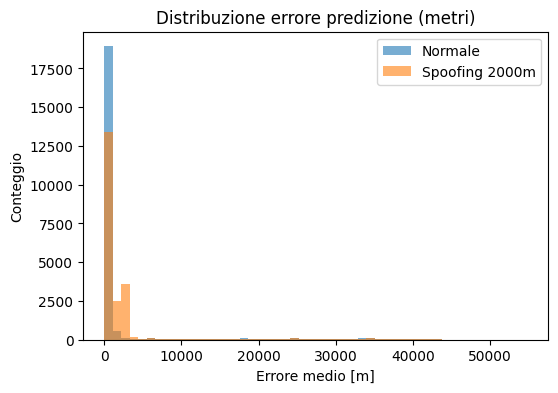

Errore medio (clean=0.02629, attack=0.02732) σ_clean=0.11675 σ_attack=0.11775
Drift 2000 m → AUROC=0.912  AUPRC=0.448  TPR@99p=1.0%

=== Drift 5000 m ===
Errore medio in metri: clean=2401.64 m, attack=3898.36 m


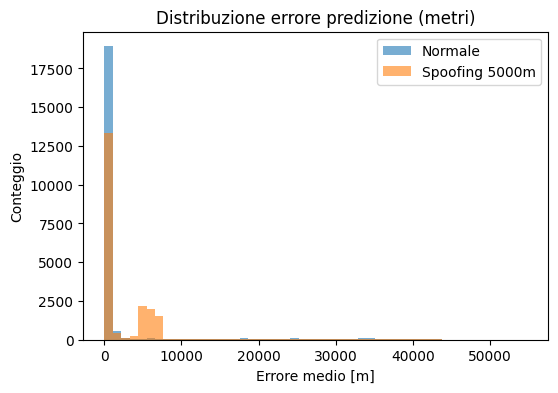

Errore medio (clean=0.02629, attack=0.03149) σ_clean=0.11675 σ_attack=0.11920
Drift 5000 m → AUROC=0.925  AUPRC=0.481  TPR@99p=1.0%

=== Drift 10000 m ===
Errore medio in metri: clean=2401.64 m, attack=5509.01 m


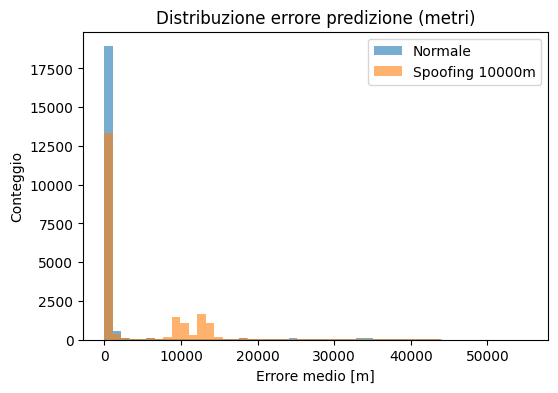

Errore medio (clean=0.02629, attack=0.04534) σ_clean=0.11675 σ_attack=0.12423
Drift 10000 m → AUROC=0.937  AUPRC=0.521  TPR@99p=1.2%

=== Drift 20000 m ===
Errore medio in metri: clean=2401.64 m, attack=8673.80 m


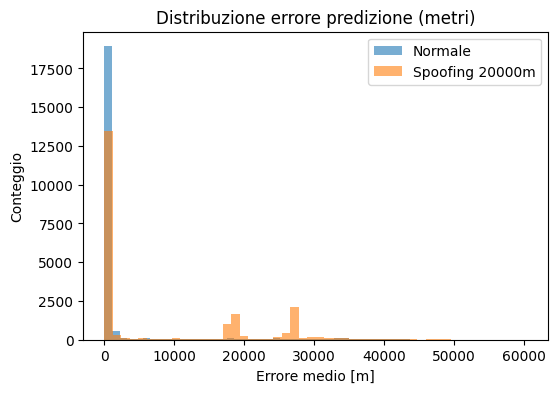

Errore medio (clean=0.02629, attack=0.09873) σ_clean=0.11675 σ_attack=0.17551
Drift 20000 m → AUROC=0.959  AUPRC=0.632  TPR@99p=1.7%

[Risultati sweep]
 2000 m  AUROC=0.912  AUPRC=0.448  TPR@99p=1.0%
 5000 m  AUROC=0.925  AUPRC=0.481  TPR@99p=1.0%
10000 m  AUROC=0.937  AUPRC=0.521  TPR@99p=1.2%
20000 m  AUROC=0.959  AUPRC=0.632  TPR@99p=1.7%


In [44]:
# === Predizioni su test pulito ===
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_test_t = to_tensor(X_test)
model.eval()
with torch.no_grad():
    pred_clean = model(X_test_t).numpy()

err_clean = np.mean((pred_clean - y_test)**2, axis=1)

# === Funzione di valutazione attacco ===
def eval_attack(drift_m):
    # --- genera dati attaccati ---
    X_attack, labels = simulate_silent_drift(
        X_test, std_x_m=STD_X_M, meters=drift_m, prob=ATTACK_PROB
    )

    # --- predizione ---
    with torch.no_grad():
        pred_att = model(to_tensor(X_attack)).numpy()

    # --- errori normalizzati e in metri ---
    err_att = np.mean((pred_att - y_test)**2, axis=1)
    err_clean_m = np.sqrt(((pred_clean - y_test)**2).sum(axis=1)) * STD_X_M
    err_att_m   = np.sqrt(((pred_att   - y_test)**2).sum(axis=1)) * STD_X_M

    print(f"\n=== Drift {drift_m} m ===")
    print(f"Errore medio in metri: clean={err_clean_m.mean():.2f} m, attack={err_att_m.mean():.2f} m")

    # --- metriche di detection ---
    labels_all = np.concatenate([np.zeros_like(err_clean), labels])
    scores_all = np.concatenate([err_clean, err_att])
    auc_score  = roc_auc_score(labels_all, scores_all)
    aupr_score = average_precision_score(labels_all, scores_all)

    # --- istogramma comparativo ---
    plt.figure(figsize=(6,4))
    plt.hist(err_clean_m, bins=50, alpha=0.6, label='Normale')
    plt.hist(err_att_m,   bins=50, alpha=0.6, label=f'Spoofing {drift_m}m')
    plt.title("Distribuzione errore predizione (metri)")
    plt.xlabel("Errore medio [m]")
    plt.ylabel("Conteggio")
    plt.legend()
    plt.show()

    # --- soglia e detection rate ---
    thr = np.percentile(err_clean, 99)
    tpr_99 = float(np.mean(err_att > thr))

    print(f"Errore medio (clean={err_clean.mean():.5f}, attack={err_att.mean():.5f}) "
          f"σ_clean={err_clean.std():.5f} σ_attack={err_att.std():.5f}")
    print(f"Drift {drift_m} m → AUROC={auc_score:.3f}  AUPRC={aupr_score:.3f}  TPR@99p={tpr_99*100:.1f}%")

    return drift_m, auc_score, aupr_score, tpr_99, err_att, labels_all, scores_all, pred_att


# === Controllo STD ===
if STD_X_M is None:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
    xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
    STD_X_M = float(xs_m.std())
    STD_Y_M = float(ys_m.std())
    print(f"[Auto-calibrato] STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

print("DEBUG STD:", STD_X_M, STD_Y_M)

# === Sweep attacchi ===
if ATTACK_ENABLE:
    results = []
    last_err_att = None
    labels_all, scores_all, pred_attack = None, None, None  # inizializza

    if DRIFT_SWEEP_METERS:
        for d in DRIFT_SWEEP_METERS:
            drift_m, auc, aupr, tpr, err_att, labels_all, scores_all, pred_attack = eval_attack(d)
            results.append((drift_m, auc, aupr, tpr))
            last_err_att = err_att

        print("\n[Risultati sweep]")
        for d, auc, aupr, tpr in results:
            print(f"{d:>5} m  AUROC={auc:.3f}  AUPRC={aupr:.3f}  TPR@99p={tpr*100:.1f}%")
    else:
        _, _, _, _, last_err_att, labels_all, scores_all, pred_attack = eval_attack(DRIFT_METERS)

# **Plot errori temporali**

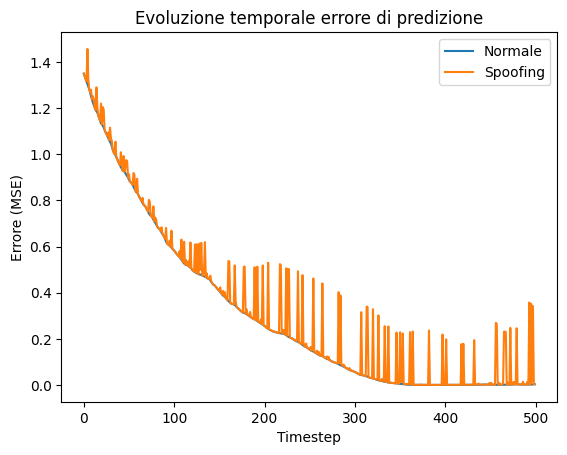

In [45]:
plt.plot(err_clean[:500], label='Normale')
plt.plot(err_att[:500], label='Spoofing')
plt.xlabel("Timestep"); plt.ylabel("Errore (MSE)")
plt.title("Evoluzione temporale errore di predizione")
plt.legend(); plt.show()

# **ROC / PR curve**

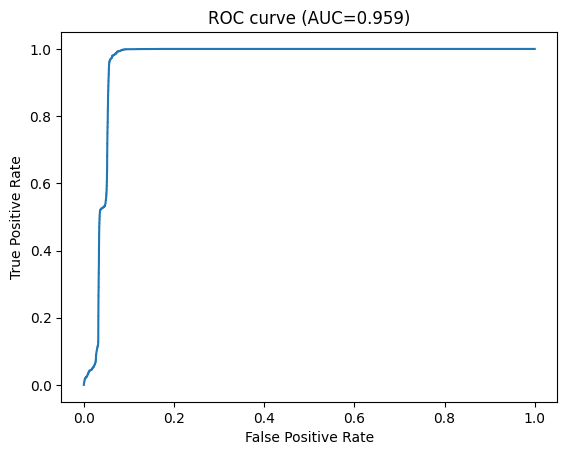

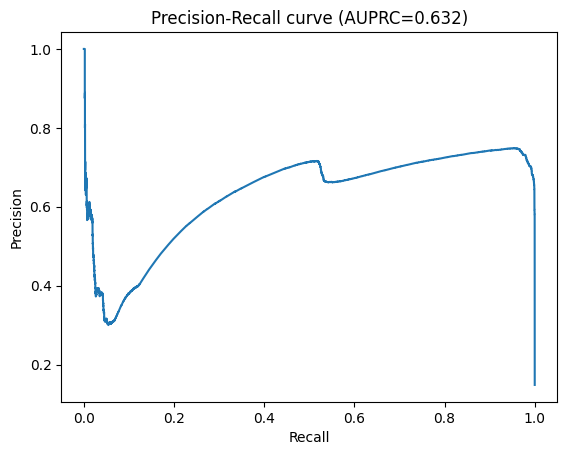

In [46]:
# --- importa la funzione originale ---
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- ricalcola ---
fpr, tpr, _ = roc_curve(labels_all, scores_all)
prec, rec, _ = precision_recall_curve(labels_all, scores_all)

roc_auc = auc(fpr, tpr)
pr_auc  = auc(rec, prec)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={roc_auc:.3f})")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AUPRC={pr_auc:.3f})")
plt.show()


# **Heatmap “offset vs TPR”**

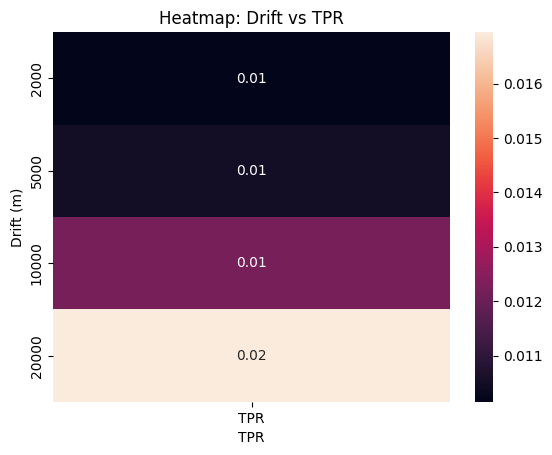

In [47]:
data = pd.DataFrame(results, columns=["drift_m", "AUROC", "AUPRC", "TPR"])
sns.heatmap(data.pivot_table(index="drift_m", values="TPR"), annot=True, fmt=".2f")
plt.title("Heatmap: Drift vs TPR"); plt.xlabel("TPR"); plt.ylabel("Drift (m)")
plt.show()

# **Case study: traiettoria su piano cartesiano**

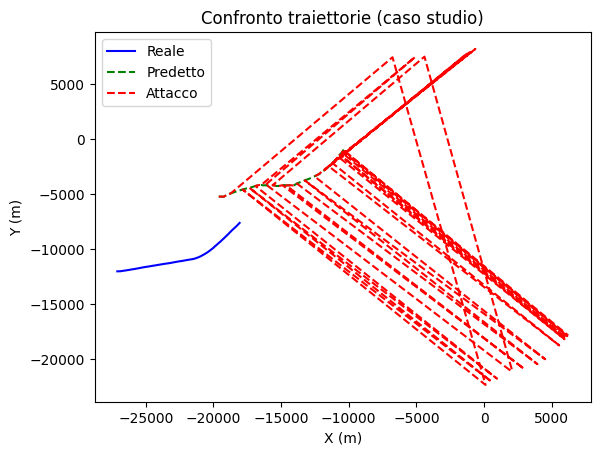

In [48]:
idx = 1000  # scegli un segmento
plt.plot(y_test[idx:idx+60,0]*STD_X_M, y_test[idx:idx+60,1]*STD_Y_M, 'b-', label="Reale")
plt.plot(pred_clean[idx:idx+60,0]*STD_X_M, pred_clean[idx:idx+60,1]*STD_Y_M, 'g--', label="Predetto")
plt.plot(pred_attack[idx:idx+60,0]*STD_X_M, pred_attack[idx:idx+60,1]*STD_Y_M, 'r--', label="Attacco")
plt.legend(); plt.xlabel("X (m)"); plt.ylabel("Y (m)")
plt.title("Confronto traiettorie (caso studio)")
plt.show()